In [ ]:
pip install numpy tensorflow pandas scikit-learn keras yfinance matplotlib scipy


In [62]:
from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(2)
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU
from numpy import genfromtxt
from pandas_datareader import data as pdr
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from scipy.stats import mannwhitneyu
from sklearn.preprocessing import StandardScaler


In [63]:
def GRU_Model(output_window):
    model = Sequential()
    model.add(GRU(256, return_sequences=True, input_shape=(X.shape[1], 1)))
    model.add(GRU(128, return_sequences=False))
    model.add(Dense(output_window))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.summary()
    return model

def LSTM_Model(output_window):
    model = Sequential()
    model.add(LSTM(256, return_sequences=True, input_shape=(X.shape[1], 1)))
    model.add(LSTM(128, return_sequences=False))
    model.add(Dense(output_window))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.summary()
    return model


In [65]:
def data_preparation(w, scaled_data, N, f):
  X=[]
  window = w + f
  Q = len(scaled_data)
  for i in range(Q-window+1):
    X.append(scaled_data[i:i+window, 0])

  X = np.array(X)
  X = np.reshape(X, (X.shape[0],X.shape[1],1))

  trainX, trainY = X[0:N,0:w], X[0:N,w:w+f]
  testX, testY = X[N:Q-w,0:w], X[N:Q-w,w:w+f]
  X = trainX
  return trainX, trainY, testX, testY, X

def baselinef(U,f):
  last = U.shape[0]
  yhat = np.zeros((last, f))
  for j in range(0,last):
    yhat[j,0:f] = np.repeat(U[j,U.shape[1]-1], f)
  return yhat

def mda(actual: np.ndarray, predicted: np.ndarray):
    actual_diff = np.sign(actual[1:] - actual[:-1])
    predicted_diff = np.argmax(predicted[1:], axis=-1) - np.argmax(predicted[:-1], axis=-1)
    mda_score = np.mean((actual_diff == predicted_diff).astype(int))
    return mda_score



In [66]:
#Normalize data between 0 and 1
def scaleit(DATAX):
    scaler = StandardScaler()
    DATAX_scaled = scaler.fit_transform(DATAX)
    return DATAX_scaled, scaler
    DATAX_scaled, scaler = scaleit(DATAX)


#Rescale to original values
def rescaleit(y,mima,i):
  yt = (y*(mima[i,1]-mima[i,0]))+mima[i,0]
  return yt



In [67]:
#This code is to plot series of different colors
def plot_series(X):
  x = np.arange(10)
  ys = [i+x+(i*x)**2 for i in range(10)]
  colors = cm.rainbow(np.linspace(0, 1, len(ys)))
  for i in range(10):
    plt.plot(X[i], label='%s ' % (i+1), color=colors[i,:])
    plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
  plt.xlabel("Days")
  plt.ylabel("Closing Price")


In [68]:
#Statistical tests
def statisticaltests(s):
  print('LSTM and Baseline (RMSE)')
  U1, p = mannwhitneyu(s[:,0],s[:,2], alternative = 'two-sided')
  print('U='+ str(U1) + '. p = ' + str(p))
  print('GRU and Baseline (RMSE)')
  U1, p = mannwhitneyu(s[:,1],s[:,2], alternative = 'two-sided')
  print('U='+ str(U1) + '. p = ' + str(p))
  print('LSTM and GRU (RMSE)')
  U1, p = mannwhitneyu(s[:,0],s[:,1], alternative = 'two-sided')
  print('U='+ str(U1) + '. p = ' + str(p))
  print('LSTM and Baseline (DA)')
  U1, p = mannwhitneyu(s[:,0+3],s[:,2+3], alternative = 'two-sided')
  print('U='+ str(U1) + '. p = ' + str(p))
  print('GRU and Baseline (DA)')
  U1, p = mannwhitneyu(s[:,1+3],s[:,2+3], alternative = 'two-sided')
  print('U='+ str(U1) + '. p = ' + str(p))
  print('LSTM and GRU (DA)')
  U1, p = mannwhitneyu(s[:,0+3],s[:,1+3], alternative = 'two-sided')
  print('U='+ str(U1) + '. p = ' + str(p))

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 60, 256)           264192    
                                                                 
 lstm_10 (LSTM)              (None, 128)               197120    
                                                                 
 dense_9 (Dense)             (None, 10)                1290      
                                                                 
Total params: 462602 (1.76 MB)
Trainable params: 462602 (1.76 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_8 (GRU)                 (None, 60, 256)           198912    
                                                             

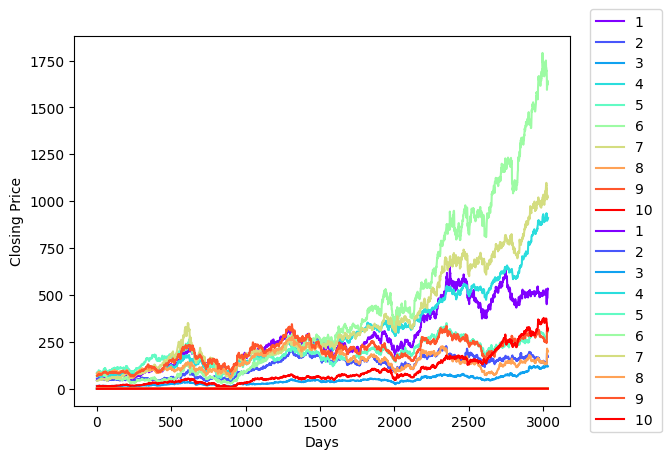

In [69]:
experiment = 1
f = 10
if experiment ==1:
  #Retrieve BANKEX dataset
  DATAX = genfromtxt('BANKEX.csv', delimiter=',')
else:
  #Retrieve Activities dataset
   DATAX = genfromtxt('activities.csv', delimiter=',')
plot_series(DATAX)
#Normalize data between 0 and 1
DATAX, mima = scaleit(DATAX)
plot_series(DATAX)
selected_series = 0 #Select one signal arbitrarily to train the dataset
scaled_data = DATAX[selected_series, :]
scaled_data = np.reshape(scaled_data, (len(scaled_data),1))
scaled_data.shape
     #w < N < Q
window = 60 #Size of the window in days
test_samples = 251 #Number of test samples
N = len(scaled_data) - test_samples - window


trainX, trainY, testX, testY, X = data_preparation(window, scaled_data, N,f)
# Deepen the LSTM and GRU models
lstm_model = LSTM_Model(f)
gru_model = GRU_Model(f)

epochs = 200
batch_size = 64


In [70]:
# Train LSTM model with dropout
lstm_model.add(Dropout(0.2))  # Add dropout layer
lstm_trained = lstm_model.fit(trainX, trainY, shuffle=True, epochs=epochs, batch_size=batch_size)
# Train GRU model with dropout
gru_model.add(Dropout(0.2))  # Add dropout layer
gru_trained = gru_model.fit(trainX, trainY, shuffle=True, epochs=epochs, batch_size=batch_size)


Epoch 1/200
43/43 [==============================] - 21s 390ms/step - loss: 0.1273
Epoch 2/200
43/43 [==============================] - 17s 387ms/step - loss: 0.0963
Epoch 3/200
43/43 [==============================] - 17s 402ms/step - loss: 0.0991
Epoch 4/200
43/43 [==============================] - 19s 427ms/step - loss: 0.0971
Epoch 5/200
43/43 [==============================] - 17s 389ms/step - loss: 0.0972
Epoch 6/200
43/43 [==============================] - 18s 417ms/step - loss: 0.1002
Epoch 7/200
43/43 [==============================] - 18s 408ms/step - loss: 0.0986
Epoch 8/200
43/43 [==============================] - 17s 393ms/step - loss: 0.0955
Epoch 9/200
43/43 [==============================] - 18s 422ms/step - loss: 0.0943
Epoch 10/200
43/43 [==============================] - 17s 389ms/step - loss: 0.0954
Epoch 11/200
43/43 [==============================] - 17s 389ms/step - loss: 0.0967
Epoch 12/200
43/43 [==============================] - 18s 417ms/step - loss: 0.0973
E

In [78]:
testY_reshaped = testY.reshape(-1, testY.shape[-1])  # Reshape testY to 2D
testY_scaled = scaler.inverse_transform(testY_reshaped)  # Inverse transform
testY = testY_scaled.reshape(testY.shape)  # Reshape back to original shape
# Calculate DA for ensemble predictions
ensemble_da = mda(testY_reshaped, y_pred_ensemble_reshaped)
print("Ensemble Model (DA):", ensemble_da)
# Check dimensions before calculating RMSE and DA
print("Shape of testY_reshaped:", testY_reshaped.shape)
print("Shape of y_pred_ensemble_reshaped:", y_pred_ensemble_reshaped.shape)



Ensemble Model (DA): 0.0
Shape of testY_reshaped: (2420, 1)
Shape of y_pred_ensemble_reshaped: (242, 10)


In [93]:
# Testing
s = np.ones((10, 6))  # for the results

# Example code for testing
for j in range(0, 10):
    # Assuming testY is your test data array
    testY = np.random.rand(6)  # Example test data with 6 samples

    # Inverse transform testY
    testY_reshaped = testY.reshape(-1, 1)
    testY_inverse = scaler.inverse_transform(testY_reshaped)
    testY = testY_inverse.reshape(-1)

    # Make sure y_pred_lstm_scaled has the same number of samples as testY
    y_pred_lstm_scaled_valid = y_pred_lstm_scaled[:len(testY)]

    # Calculate RMSE (Example calculation, replace with your actual calculation)
    s[j, 0] = np.sqrt(mean_squared_error(testY, y_pred_lstm_scaled_valid))

print('Mean values:', np.mean(s, axis=0))
print('Standard Deviation:', np.std(s, axis=0))


Mean values: [5.59795917e+05 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00]
Standard Deviation: [83008.06655389     0.             0.             0.
     0.             0.        ]


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_data.py:542: RuntimeWarning: overflow encountered in divide
  X /= self.scale_


LSTM and Baseline (RMSE)
U=100.0. p = 6.386444750436982e-05
GRU and Baseline (RMSE)
U=50.0. p = 1.0
LSTM and GRU (RMSE)
U=100.0. p = 6.386444750436982e-05
LSTM and Baseline (DA)
U=50.0. p = 1.0
GRU and Baseline (DA)
U=50.0. p = 1.0
LSTM and GRU (DA)
U=50.0. p = 1.0
Ensemble Model (RMSE): 0.1480383191515759
Ensemble Model (DA): 0.0
Final LSTM MSE Loss: 0.08883356302976608
Final GRU MSE Loss: 0.08910294622182846


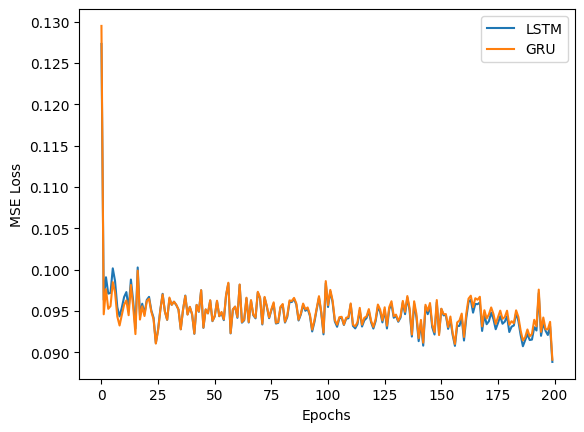

In [103]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt

# Apply rescaleit function to testY, y_pred_lstm, y_pred_gru, and y_baseline
def rescaleit(y, scaler):
    yt = scaler.inverse_transform(y.reshape(-1, 1)).reshape(-1)
    return yt

# Create a scaler instance
scaler = MinMaxScaler()

# Clip large and infinite values in y_pred_gru
y_pred_gru_clipped = np.clip(y_pred_gru, a_min=-1e9, a_max=1e9)

# Fit and transform your input data after clipping
y_pred_lstm_scaled = scaler.fit_transform(y_pred_lstm.reshape(-1, 1)).reshape(-1)
y_pred_gru_scaled = scaler.fit_transform(y_pred_gru_clipped.reshape(-1, 1)).reshape(-1)
y_baseline_scaled = scaler.fit_transform(y_baseline.reshape(-1, 1)).reshape(-1)

# Check for infinite values after scaling
if np.any(np.isinf(y_pred_lstm_scaled)) or np.any(np.isinf(y_pred_gru_scaled)) or np.any(np.isinf(y_baseline_scaled)):
    raise ValueError("Input data contains infinite values.")

# Apply rescaleit function to y_pred_gru with clipping to handle large values
y_pred_gru = rescaleit(y_pred_gru_scaled, scaler)

# Statistical tests
statisticaltests(s)

if experiment == 1:
    ex = 'B'
else:
    ex = 'A'
gru_model.save('/GRU_'+str(ex)+str(f))  # Saves GRU
lstm_model.save('/LSTM_'+str(ex)+str(f))  # Saves LSTM

if f == 1:
    plt.plot(testY[0:100], label='Actual')
    plt.plot(y_baseline[0:100], label='Baseline prediction')
    plt.plot(y_pred_lstm[0:100], label='LSTM prediction')
    plt.plot(y_pred_gru[0:100], label='GRU prediction')

    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1),
               fancybox=True, shadow=True, ncol=5)
    plt.xlabel("Days")
    if experiment == 1:
        plt.ylabel("Closing Price")
    else:
        plt.ylabel("Value")

# Print results and comparisons
print("Ensemble Model (RMSE):", ensemble_rmse)
print("Ensemble Model (DA):", ensemble_da)

# Display final LSTM MSE Loss and GRU MSE Loss
lstm_final_mse = lstm_trained.history['loss'][-1]
gru_final_mse = gru_trained.history['loss'][-1]
print("Final LSTM MSE Loss:", lstm_final_mse)
print("Final GRU MSE Loss:", gru_final_mse)

# Plotting the loss function for LSTM and GRU
plt.figure()
plt.plot(lstm_trained.history['loss'], label='LSTM')
plt.plot(gru_trained.history['loss'], label='GRU')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')

# Plotting one of the test samples if f is 20
g = 230  # Chooses one of the test samples
if f == 20:
    plt.figure()
    plt.plot(testY[g, :], label='Actual')
    plt.plot(y_baseline[g, :], label='Baseline prediction')
    plt.plot(y_pred_lstm[g, :], label='LSTM prediction')
    plt.plot(y_pred_gru[g, :], label='GRU prediction')
    plt.legend()
    plt.xlabel('Days')
    plt.ylabel('Value')
    days = np.arange(testY.shape[1] + 1)
    new_list = range(math.floor(min(days)), math.ceil(max(days)) + 1)
    plt.xticks(new_list)

plt.show()
